# Prerequisites

In [1]:
import time
time_start = time.time()

In [2]:
!pip install pandas numpy scikit-learn matplotlib seaborn skorch
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/rocm5.6
#Uninstall ipykernel
#!pip uninstall ipykernel -y

Looking in indexes: https://download.pytorch.org/whl/rocm5.6


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, StratifiedKFold
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
#List available devices for pytorch
gpus = [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]
for i in gpus:
    print(i)
#List available CPUs for pytorch
print(torch.device('cpu'))

print("Current device", torch.cuda.current_device())

PyTorch Version: 2.1.0+rocm5.6
CUDA Available: True
AMD Radeon RX 6950 XT
AMD Radeon Graphics
cpu
Current device 0


# Importing the data

In [4]:
#Open blinks data from csv

#Make a filename that is a relative path to the data
filename = '../../Data/blinks.txt'

data = pd.read_csv(filename, sep=",", header=None)

In [5]:
#Removing columns 12-22
data = data.drop(data.columns[12:22], axis=1)
#Remove the first 1000 samples
data = data.drop(data.index[0:1000])
#Reindex the data
data = data.reset_index(drop=True)
data

,0,1,2,3,4,5,6,7,8,9,10,11,22,23
0,232,65204.73,51338.89,-15532.88,-21018.39,6220.27,-3776.89,6869.58,1464.67,0.038,0.770,0.604,1557936057322,12:00:57.322
1,233,64880.61,50822.25,-15317.76,-20962.36,6507.96,-3452.81,7167.31,1747.48,0.030,0.776,0.612,1557936057328,12:00:57.328
2,234,64431.11,50216.86,-15067.89,-20703.97,6782.68,-3201.98,7451.71,2030.59,0.030,0.776,0.612,1557936057328,12:00:57.328
3,235,64745.36,50724.85,-15302.41,-20786.18,6471.43,-3542.17,7128.49,1724.59,0.030,0.776,0.612,1557936057336,12:00:57.336
4,236,65189.55,51327.16,-15519.71,-20994.57,6219.91,-3786.32,6864.22,1460.75,0.030,0.776,0.612,1557936057336,12:00:57.336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21485,213,58750.42,47034.95,-18637.04,-27128.40,-9182.90,-18376.35,-5918.16,-6498.79,0.034,0.762,0.610,1557936143152,12:02:23.152
21486,214,59029.14,47391.53,-18737.73,-27217.09,-9327.85,-18544.50,-6069.39,-6654.94,0.028,0.768,0.614,1557936143152,12:02:23.152
21487,215,58890.72,47196.80,-18850.75,-27389.65,-9400.32,-18621.62,-6141.32,-6739.32,0.028,0.768,0.614,1557936143159,12:02:23.159
21488,216,58567.63,46769.70,-18777.12,-27361.26,-9255.01,-18427.36,-5976.43,-6570.79,0.028,0.768,0.614,1557936143166,12:02:23.166


0        14.686
1        14.762
2        14.762
3        14.762
4        14.762
          ...  
21485    14.636
21486    14.686
21487    14.686
21488    14.686
21489    14.686
Length: 21490, dtype: float64


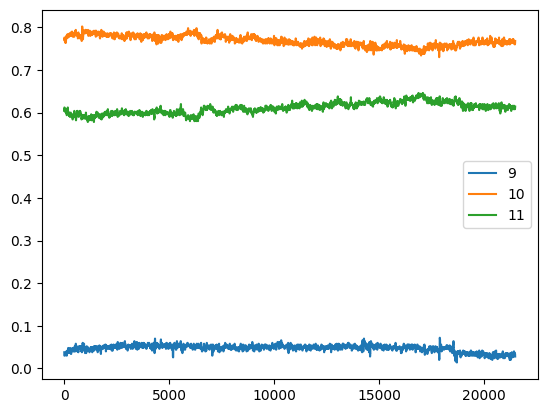

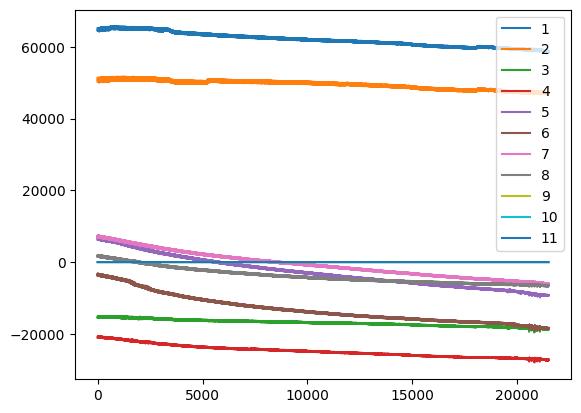

In [6]:
#Create a dataframe for the data, columns 1-11
useful_data = data.iloc[:,1:12]

#Create alpha labels, columns 9-11
alphaLabels = data.iloc[:,9:12]

#Create a 1d dataframe of the alphas summed
alphaSum = alphaLabels.mul([9,10,11]).sum(axis=1)

#Plot alpha labels
alphaLabels.plot()

#Ploting the data
useful_data.plot()

print(alphaSum)

In [7]:
n_samps = 21490
n_blinks = 40
lenRangeDown = 30
lenRangeUp = 60
labels = pd.DataFrame()

#Append 21491 norm labels to the dataframe
for i in range(n_samps):
    labels = labels._append(['norm'])

#Generate random blink labels
for _ in range(n_blinks):
    # Randomly select the start and end indices for each blink
    start_idx = random.randint(0, n_samps - lenRangeUp)
    end_idx = start_idx + random.randint(lenRangeDown, lenRangeUp)
    
    # Set the blink labels for the selected range
    for i in range(start_idx, end_idx):
        labels.iloc[i] = 'blink'

labels.value_counts()

norm     19738
blink     1752
Name: count, dtype: int64

# Pytorch GPU setup

In [8]:
#Set labels up for pytorch
labels = labels.replace({'norm': 0, 'blink': 1})

torchData = useful_data.copy()
torchLabels = labels.copy()

In [9]:
# Modify your model class to accept hyperparameters
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)  # Output is a binary classification, so one output unit

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Define your training loop as a function
def train_and_evaluate(model, X_train, y_train, X_test, y_test, epoch_num, batch_size, loss_fn, optimizer):
    start_time = time.time()
    for _ in range(epoch_num):
        model.train()
        for i in range(0, len(X_train), batch_size):
            inputs = torch.tensor(X_train[i:i + batch_size], dtype=torch.float32, device=torch.device('cuda'))
            labels = torch.tensor(y_train[i:i + batch_size], dtype=torch.float32, device=torch.device('cuda'))

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        test_inputs = torch.tensor(X_test, dtype=torch.float32, device=torch.device('cuda'))
        predictions = model(test_inputs)
        predicted_labels = (predictions > 0.5).float()
        accuracy = accuracy_score(y_test, predicted_labels.cpu().numpy())
    
    end_time = time.time()
    return accuracy, end_time - start_time

# Split the data into training and testing sets (80/20%)
train_data, test_data, train_labels, test_labels = train_test_split(torchData, torchLabels, test_size=0.2, random_state=42)
train_data = train_data.to_numpy()
train_labels = train_labels.to_numpy()
test_data = test_data.to_numpy()
test_labels = test_labels.to_numpy()

# Convert your data into PyTorch tensors
train_data_tensor = torch.tensor(train_data, dtype=torch.float32)
# Reshape the data tensor
train_data_tensor = train_data_tensor.view(-1, 11)

train_labels_tensor = torch.tensor(train_labels)
train_labels_tensor = train_labels_tensor.view(-1)

test_data_tensor = torch.tensor(test_data, dtype=torch.float32)

parameter_grid = {
    'epoch_num': [10, 20, 30],
    'batch_size': [32, 64, 128],
    'hidden_size': [32, 64, 128],
    'loss': [nn.BCELoss(), nn.MSELoss(), nn.CrossEntropyLoss()],
    #'lr': [0.0001, 0.001, 0.01, 0.1],
}

results = []
device = torch.device('cuda')
for params in ParameterGrid(parameter_grid):
    model = Classifier(input_size=11, hidden_size=params['hidden_size'])
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    loss = params['loss']
    accuracy, time_taken = train_and_evaluate(model, train_data, train_labels, test_data, test_labels, params['epoch_num'], params['batch_size'], loss, optimizer)
    results.append((params, accuracy, time_taken))
    print("Model Parameters:", params)
    print("Accuracy:", accuracy)
    print("Time taken:", time_taken)

: 

# Collecting the results

In [ ]:
#Listing results for pytorch
resultsPD = pd.DataFrame(results)
resultsPD.columns = ['runDevice', 'epochNum', 'batchSize', 'loss', 'hiddenSize', 'time', 'trainAccuracy']
resultsPD = resultsPD.sort_values(by=['accuracy'], ascending=False)
resultsPD

NameError: name 'results' is not defined

# Notebook Runtime

In [ ]:
#Time to finish
time_end = time.time()
print('Time to finish:', time_end - time_start, 'seconds')

Time to finish: 280.21115589141846 seconds
